In [1]:
#!/usr/bin/python
# -*- coding:Utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fftfreq, fft, fft2, fftshift
from scipy.signal import tukey, detrend
from scipy.interpolate import interp2d
import xarray as xr



In [15]:
def compute_2d_spectrum(F,nx,ny,dx,dy):
    """
    Compute 2d spectrum by using the 
    2d fast fourier transform
    """
    ### detrend
    Fdtr = detrend(detrend(F,axis=1),axis=0)

    ## Window Tapering
    cff_tukey = 0.5
    wdw_y = tukey(ny, cff_tukey)
    wdw_x = tukey(nx, cff_tukey)
    wdw = np.outer(wdw_x,wdw_y)
    Ftpr = Fdtr * wdw[:,:]

    ### spectre 2d
    Fsp = np.zeros(Ftpr.shape)
    ld = 1./dy * 1./dx * (wdw**2).sum()

    pu = fftshift(fft2(Ftpr))
    Fsp = (np.conjugate(pu)*pu).real/ ld

    ### Wavelength and period
    kx = fftshift(fftfreq(nx,dx))
    ky = fftshift(fftfreq(ny,dy))

    return kx, ky, Fsp


def compute_constant(n):
    
    """
    Compute the constant of separation c and
    the dimension O and K of omega and k such 
    that omega = f(k) -> omega*/O = f(k*/K)
    """
    c = 1./np.sqrt((modes2.lamba.values[n])) #!!!!!!
    print('c = ',c)
    
    L = np.sqrt(c/B)
    T = 1./np.sqrt(c*B)

    O=1./(2*np.pi*T)
    K=1./(2*np.pi*L)

    return c,O,K



def rossby_relation(k,m,n,**kwargs):

    """
    approximated relation dispersion for Rossby waves
    """

    options={
        'dim':False,
        }

    options.update(kwargs)

    dim=options['dim']

    if dim==False:
        omega = -1.*(k/(k**2+2*m+1))
    if dim==True:
        c,O,K = compute_constant(n)
        omega = -1.*O*((K**-1)*k/((K**-2)*(k**2)+2*m+1))

    return omega


def gravity_relation(k,m,n,**kwargs):

    """
    Approximated relation dispersion for Inerta-Gravity waves
    """
    
    options={
        'dim':False,
        }

    options.update(kwargs)

    dim=options['dim']

    if dim==False:
        omega=np.sqrt(k**2+2*m+1)
    if dim==True:

        c,O,K = compute_constant(n)
        omega= O*np.sqrt((K**-2)*(k**2)+2*m+1)

    return omega


def yanai_relation(k,n,**kwargs):

    """
    Relation dispersion for Yanai waves
    """
    
    options={
        'dim':False,
        }

    options.update(kwargs)

    dim=options['dim']


    if dim==False:
        omega=(1/2.)*(k+np.sqrt(k**2+4))
    if dim==True:
        c,O,K = compute_constant(n)
        omega= O*(1./2.)*((K**(-1))*k+np.sqrt((K**(-2))*(k**2)+4))

    return omega


def kelvin_relation(k,n,**kwargs):

    """
    Relation dispersion for Kelvin waves
    """
    
    options={
        'dim':False,
        }

    options.update(kwargs)

    dim=options['dim']

   
    if dim==False:
        omega=k
    if dim==True:
        c,O,K = compute_constant(n)
        omega= O*(K**-1)*k

    return omega


In [16]:
exp = 'GIGATL3_Equator'
indir = '../'
infile = indir+exp+'.nc'
data = xr.open_dataset(infile)
data = data.sel(x_rho = slice(-40,-10), y_rho = slice(-0.3,0.3))
data = data.sel(z_rho = -1000,method = "nearest")

Fsp=[]

### Resolution
dx = data['x_rho'].diff("x_rho").mean().values*111000
dt = data['time'].diff("time").mean().values.astype('timedelta64[s]').astype(np.float32)

fx = 1./dx
ft = 1./dt

u_rgrd=data.uCart.values
v_rgrd=data.vCart.values

for y_ind in range(u_rgrd.shape[1]):
    nt,nx = u_rgrd[:,y_ind,:].shape
    mt,mx = v_rgrd[:,y_ind,:].shape

    w,kx, Spu = compute_2d_spectrum(u_rgrd[:,y_ind,:],nt,nx,dt,dx)
    w ,kx , Spv = compute_2d_spectrum(v_rgrd[:,y_ind,:],mt,mx,dt,dx)
    
    Fsp.append(Spv+Spu)

Fsp = np.mean(np.array(Fsp),0)

In [17]:
# dispersion relations dimensionalisée
B=2.3e-11

indir = "../relationDispersion/modes/Off/"
modes2 = xr.open_dataset(indir + 'lambda_G6_4Y.nc')
# modes3 = modes2.modes
# modes = modes2.modes.values

In [34]:
def plot_dimensional_dispR(M_modes,N_modes,kx,w,Fsp):
    """
    Plot dispersion relation as a function of vertical modes
    n=[1,..,N_modes]
    """
    oneday=86400
    onedeg=111000
    D=True
    k=np.linspace(-5e-5,5e-5,np.shape(kx)[0]*1000)
    k = k
    
    
    f,ax1 = plt.subplots(figsize=(20,12)) 
    for n in range(0,N_modes):
        omega_Y=yanai_relation(k,n,dim=D)
        omega_K=kelvin_relation(k,n,dim=D)

        if n==1:
            lb=1
        else:
            lb=1


        for m in range(1,M_modes):
            print(m)
            omega_R=rossby_relation(k,m,n ,dim=D)
            omega_G=gravity_relation(k,m,n,dim=D)

            if m==0:
                lp='--'
            else:
                lp='-'
            
            ax1.plot(k,omega_R,color='b',lw=lb,ls=lp)
            ax1.plot(k,omega_G,color='r',lw=lb,ls=lp)

        ax1.plot(k,omega_K, color='g',lw=lb)
        ax1.plot(k,omega_Y, color='k',lw=lb)
       
    OMEGA,KX = np.meshgrid(w,kx)
    cax = ax1.contourf(-KX,OMEGA,Fsp.T*1e-14,cmap=plt.cm.OrRd)
    cbar = plt.colorbar(cax)
    ax1.set_xlim(-1.5e-5,.5e-5)
    ax1.set_ylim(0.,1e-6)
    ax1.grid('on')

    ax1.tick_params(labelsize=15)

    ax1.set_xlabel("k "+r"[$m^{-1}$]",size=15)
    ax1.set_ylabel(r"$\omega$ "+r"[$s^{-1}$]",size=15)   

    def xtick_function(r): return np.round(1./r)
    def ytick_function(r): return np.round(1./r)

    # points corresponding to experiments

    ax1.scatter(-1./(975*1000),1./(34*86400),s=150,color='y',zorder=20)
    plt.text(-1./(1025*1000),1./(33*86400),"$A_{k_1}$",fontsize=16)

    f.tight_layout()
    
    plt.show(block=True)

c =  15.46491385159851
c =  15.46491385159851
1
c =  15.46491385159851
c =  15.46491385159851
2
c =  15.46491385159851
c =  15.46491385159851
3
c =  15.46491385159851
c =  15.46491385159851
4
c =  15.46491385159851
c =  15.46491385159851
c =  6.500737270963014
c =  6.500737270963014
1
c =  6.500737270963014
c =  6.500737270963014
2
c =  6.500737270963014
c =  6.500737270963014
3
c =  6.500737270963014
c =  6.500737270963014
4
c =  6.500737270963014
c =  6.500737270963014


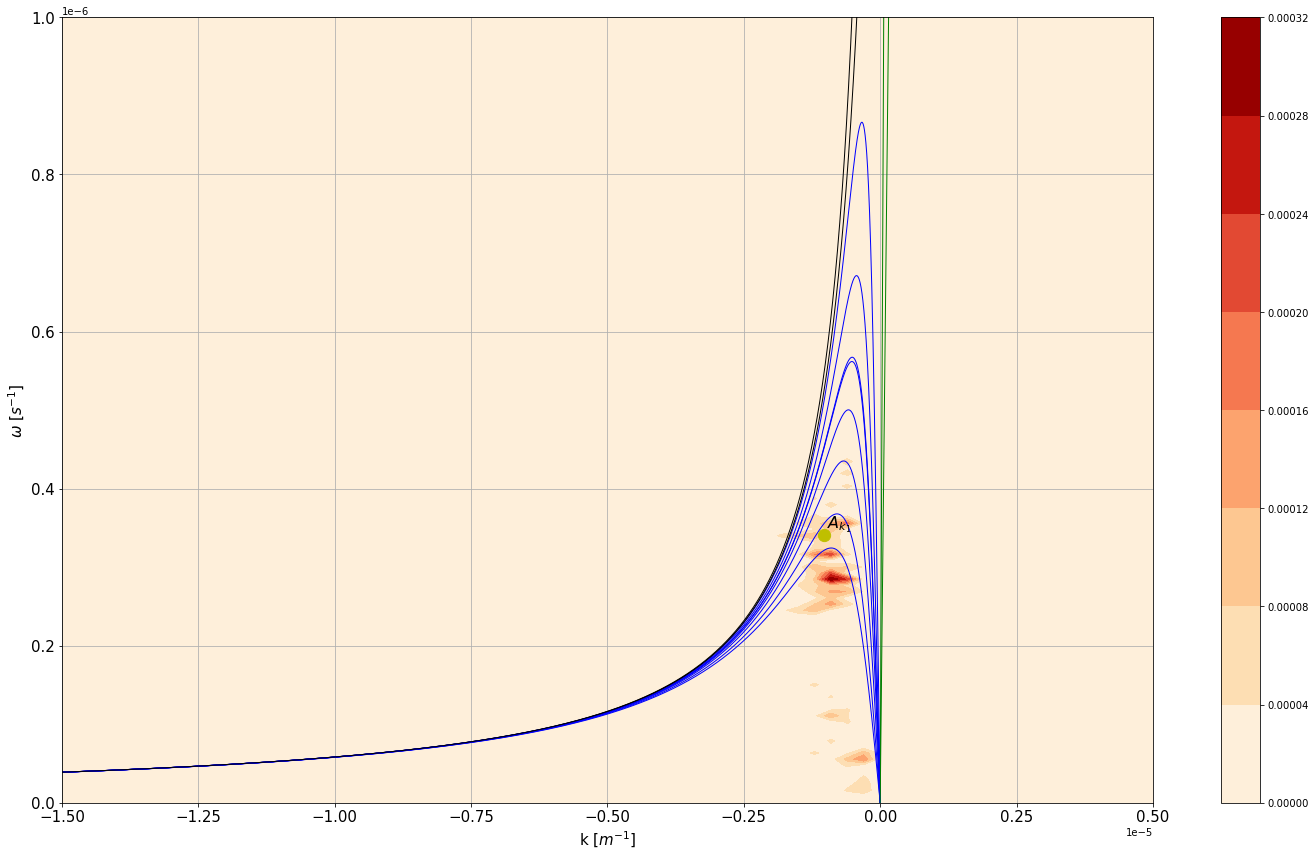

In [35]:
# OMEGA,KX = np.meshgrid(w,kx)

# plt.figure(figsize=(12,8))

# ax = plt.subplot(111)
# plt.grid('on')
    
# cax = ax.contourf(-KX,OMEGA,Fsp.T*1e-14,cmap=plt.cm.jet)
# cbar=plt.colorbar(cax)

plot_dimensional_dispR(5,2,kx,w,Fsp)

# ax.set_xlim(-4e-6,4e-6)
# ax.set_ylim(-8e-7,8e-7)

# plt.show()
# plt.close()